In [1]:
import sys
PATH_TO_ROOT='D:/My Repository'
sys.path.insert(0, PATH_TO_ROOT)

In [43]:
import pandas as pd
import numpy as np
from loess import loess_1d
from sklearn import linear_model
import matplotlib.pyplot as plt

from AlphaMobileSensing.env import environment_v2

In [44]:
datapath='D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/dynamic_50cm_DEMO.csv'
env=environment_v2.AlphaMoSeEnv(datapath, 2500, 1, 1, (15, ), ((3.5, 3),), 2, (0.5, 0.5), 500)
action_series_df=pd.read_excel('D:/My Repository/AlphaMobileSensing/data/action series for demo.xlsx')

C:\Users\qizho\AppData\Roaming\Python\Python39\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


t=1065s

In [45]:
env.reset()

num_agent=1

measurement_log_raw=np.full((len(action_series_df)-21+1,4*num_agent), np.nan)

for i in range(num_agent):
    measurement_log_raw[0,4*i:4*(i+1)]=env.obs[i]


for i in range(len(action_series_df)-21):
 
    action=[]
    for j in range(num_agent):
        array=action_series_df.iloc[i,4*j:4*(j+1)].values
        action.append(array)

    step_log=env.step(action)

    
    if step_log[0]==True:
        break
    else:
        for j in range(num_agent):
            measurement_log_raw[i+1,4*j:4*(j+1)]=env.obs[j]

In [46]:
env.agent_global_time

array([1065.])

In [47]:
measurement_log_middle=np.zeros(((len(action_series_df)-21+1)*num_agent,4))
for i in range(num_agent):
    measurement_log_middle[(len(action_series_df)-21+1)*i:(len(action_series_df)-21+1)*(i+1),:]=measurement_log_raw[:,4*i:4*(i+1)]


b=measurement_log_middle[:,2]
index=np.lexsort((b,))
measurement_log_middle=measurement_log_middle[index]


measurement_log=measurement_log_middle[~np.isnan(measurement_log_middle)]
measurement_log=measurement_log.reshape((-1,4))

In [48]:
x=measurement_log[:,0]
y=measurement_log[:,1]
t=measurement_log[:, 2]
v=measurement_log[:, 3]

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=t)

r_i=v-fglobal[1]

In [49]:
nor_measurement_log=np.zeros_like(measurement_log)
for i in range(3):
    nor_measurement_log[:,i]=(measurement_log[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())

In [50]:
reg=linear_model.LinearRegression()
reg.fit(nor_measurement_log[:, 0:3], r_i)

LinearRegression()

In [51]:
target_time=1065

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_xflat[:,0]+reg.coef_[1]*nor_xflat[:,1]+reg.coef_[2]*nor_xflat[:,2]

In [52]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

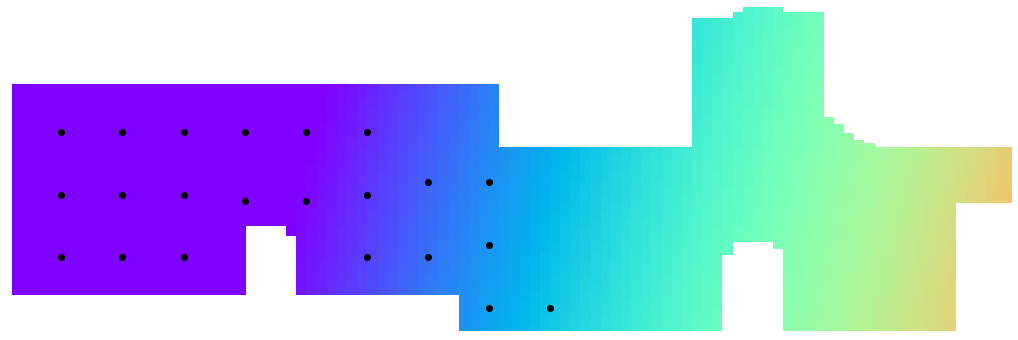

In [53]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=295, vmax=301)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [ ]:
env.request_evaluation()

In [ ]:
template=pd.read_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Dynamic_1065.csv')

X=template.iloc[:,1].values
Y=template.iloc[:,2].values

nor_X=np.zeros(len(template))
nor_Y=np.zeros(len(template))

for i in range(2):
    nor_X[:]=(X[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    nor_Y[:]=(Y[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())

Z=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_X[:]+reg.coef_[1]*nor_Y[:]+reg.coef_[2]*nor_xflat[0,2]

for i in range(len(template)):
    template.iloc[i,3]=Z[i]

template.to_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Dynamic_1065.csv', index=0)

env.compute_accuracy()

t=2005s

In [33]:
env.reset()

num_agent=1


measurement_log_raw=np.full((len(action_series_df)+1,4*num_agent), np.nan)

for i in range(num_agent):
    measurement_log_raw[0,4*i:4*(i+1)]=env.obs[i]


for i in range(len(action_series_df)):
 
    action=[]
    for j in range(num_agent):
        array=action_series_df.iloc[i,4*j:4*(j+1)].values
        action.append(array)

    step_log=env.step(action)

    
    if step_log[0]==True:
        break
    else:
        for j in range(num_agent):
            measurement_log_raw[i+1,4*j:4*(j+1)]=env.obs[j]

Episode: 6
Total moving distance of each agent (m)
[204.]
Total moving time of each agent (s)
[1390.]


In [34]:
env.agent_global_time

array([2005.])

In [35]:
measurement_log_middle=np.zeros(((len(action_series_df)+1)*num_agent,4))
for i in range(num_agent):
    measurement_log_middle[(len(action_series_df)+1)*i:(len(action_series_df)+1)*(i+1),:]=measurement_log_raw[:,4*i:4*(i+1)]

b=measurement_log_middle[:,2]
index=np.lexsort((b,))
measurement_log_middle=measurement_log_middle[index]


measurement_log=measurement_log_middle[~np.isnan(measurement_log_middle)]
measurement_log=measurement_log.reshape((-1,4))

In [37]:
x=measurement_log[:-1,0]
y=measurement_log[:-1,1]
t=measurement_log[:-1, 2]
v=measurement_log[:-1, 3]

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=t)
r_i=v-fglobal[1]

In [38]:
nor_measurement_log=np.zeros_like(measurement_log)
for i in range(3):
    nor_measurement_log[:,i]=(measurement_log[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())

In [39]:
reg=linear_model.LinearRegression()
reg.fit(nor_measurement_log[:-1, 0:3], r_i)

LinearRegression()

In [40]:
target_time=2005

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_xflat[:,0]+reg.coef_[1]*nor_xflat[:,1]+reg.coef_[2]*nor_xflat[:,2]

In [41]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

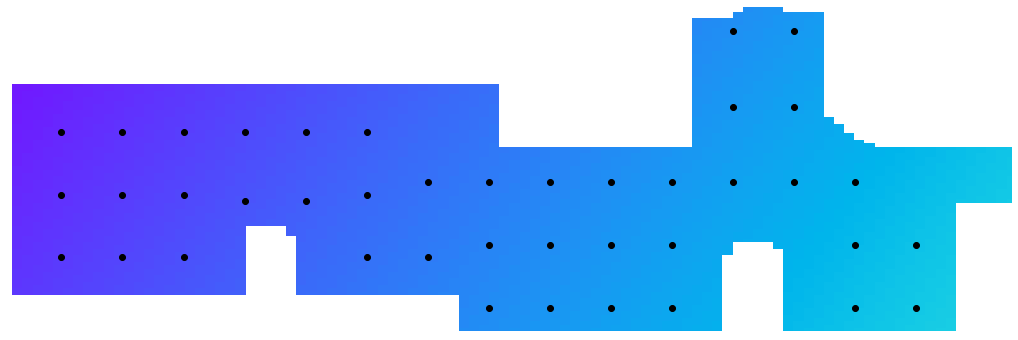

In [42]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=295, vmax=301)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [ ]:
env.request_evaluation()

In [ ]:
template=pd.read_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Dynamic_2005.csv')

X=template.iloc[:,1].values
Y=template.iloc[:,2].values

nor_X=np.zeros(len(template))
nor_Y=np.zeros(len(template))

for i in range(2):
    nor_X[:]=(X[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    nor_Y[:]=(Y[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())



Z=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_X[:]+reg.coef_[1]*nor_Y[:]+reg.coef_[2]*nor_xflat[0,2]


for i in range(len(template)):
    template.iloc[i,3]=Z[i]

template.to_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Dynamic_2005.csv', index=0)

env.compute_accuracy()